## **Problem 1) Movie Reviews dataset**


## **a)**

In [ ]:
!pip install gensim


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# loding the movies IMDB dataset
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')


In [ ]:
# display first 5 rows
df.head(5)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df.isna().sum() # checking for null

,0
review,0
sentiment,0


In [ ]:
df.dtypes

,0
review,object
sentiment,object


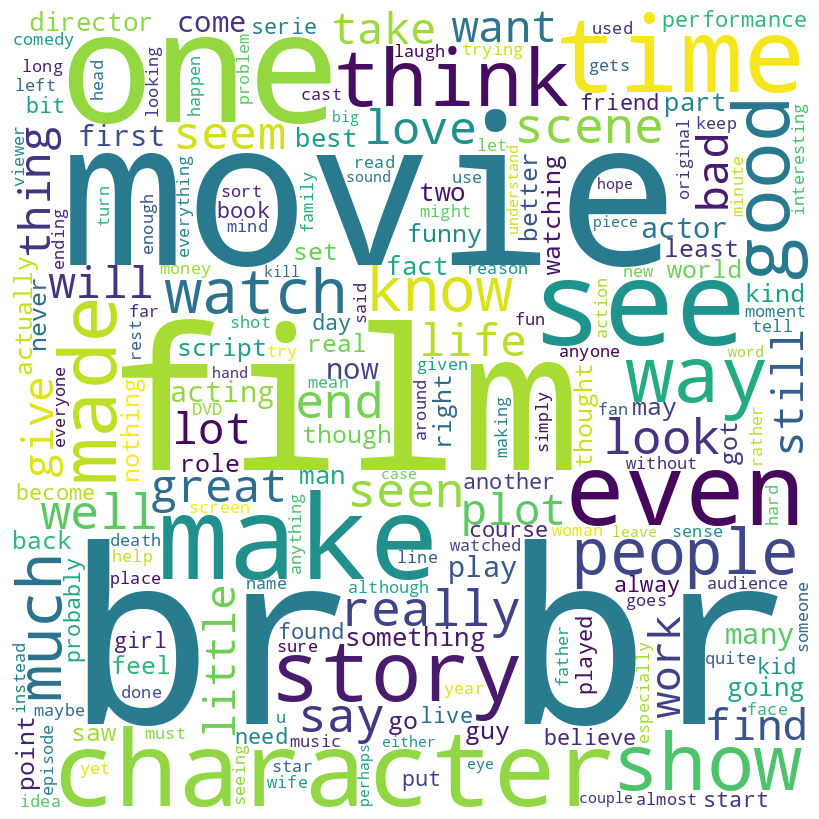

In [ ]:
# word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Concatenating all reviews into a single string
text = ' '.join(df['review'].tolist())

# Generating the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plotting the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [ ]:
# instll n import contractions library
!pip install contractions

from contractions import contractions_dict


In [ ]:
# Defining the stopword list and the lemmatizer
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
# Defining a function for preprocessing
def preprocess_text(text):

    # Removing HTML tags
    text = re.sub('<[^>]+>', '', text)

    # Converting to lower case
    text = text.lower()

    # Expanding contractions
    words = []
    for word in word_tokenize(text):      #tokenization
        if word in contractions_dict:
            words.extend(word_tokenize(contractions_dict[word]))
        else:
            words.append(word)

    # Removing punctuation
    words = [word for word in words if word.isalpha()]

    # Removing stopwords
    words = [word for word in words if word not in stopwords_list]

    # Lemmatizing
    words = [lemmatizer.lemmatize(word) for word in words]

    # Joining the words back into a single string
    text = ' '.join(words)

    return text


In [ ]:
df['preprocessed_review'] = df['review'].apply(lambda x: preprocess_text(x))
#adding the new column for preprocessed words

In [ ]:
df.head(4)

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...


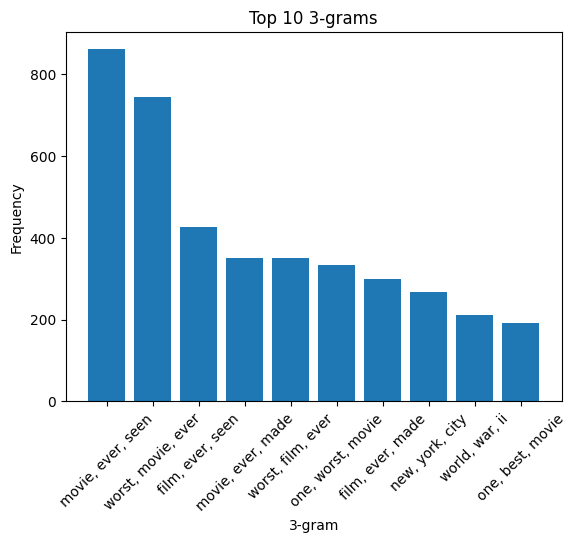

In [ ]:
from nltk import ngrams
from collections import Counter

# Define the text
text = " ".join(df.preprocessed_review.tolist())

# Generating the tri-grams
n = 3
ngrams_list = ngrams(text.split(), n)
ngrams_freq = Counter(ngrams_list)

# Plotting the top 10 most frequent words
top_ngrams = ngrams_freq.most_common(10)
x_labels = [', '.join(words) for words, count in top_ngrams]
y_values = [count for words, count in top_ngrams]

plt.bar(x_labels, y_values)
plt.xticks(rotation=45)
plt.xlabel(f'{n}-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 {n}-grams')
plt.show()


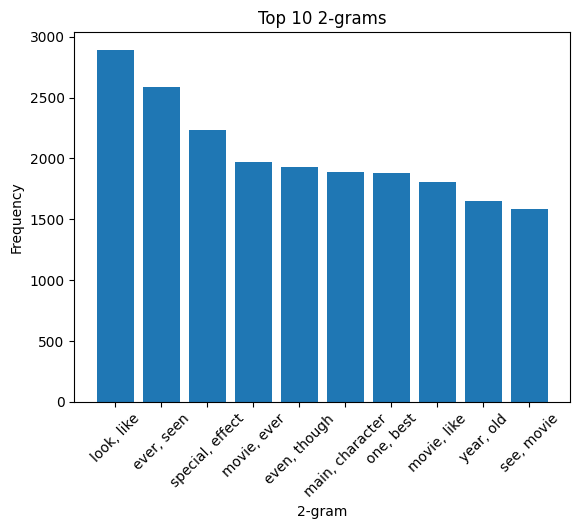

In [ ]:
# Define the text
text = " ".join(df.preprocessed_review.tolist())

# Generating the bi-grams
n = 2
ngrams_list = ngrams(text.split(), n)
ngrams_freq = Counter(ngrams_list)

# Plotting the top 10 most frequent words
top_ngrams = ngrams_freq.most_common(10)
x_labels = [', '.join(words) for words, count in top_ngrams]
y_values = [count for words, count in top_ngrams]

plt.bar(x_labels, y_values)
plt.xticks(rotation=45)
plt.xlabel(f'{n}-gram')
plt.ylabel('Frequency')
plt.title(f'Top 10 {n}-grams')
plt.show()

#**b)**

In [ ]:
#imports

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [ ]:
labels = np.array(df['sentiment'].map({'positive': 1, 'negative': 0})) # labelling the sentiment(target) column

In [ ]:
# splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], labels, test_size=0.2, random_state=42, stratify= labels)

In [ ]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index
max_length= 100 # taking the max length as 100
train_data = pad_sequences(train_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)


In [ ]:
train_data.shape, test_data.shape

((40000, 100), (10000, 100))

grugrrnnrrrrvd

In [ ]:
X_train_tokens = [text.split() for text in X_train]

w2v_rnn = Word2Vec(sentences=X_train_tokens,
                   vector_size=100,
                   window=5,
                   min_count=1,
                   workers=4,
                   sg=0)  # CBOW

embedding_dim = 100
embedding_matrix_rnn = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in w2v_rnn.wv:
        embedding_matrix_rnn[i] = w2v_rnn.wv[word]


In [ ]:
#build and compile the RNN model
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix_rnn],
                        input_length=max_length,
                        trainable=False))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
#train the RNN model
history_rnn = model_rnn.fit(train_data, y_train,
                            epochs=100,
                            batch_size=64,
                            validation_split=0.2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=8)])


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6877 - loss: 0.5976 - val_accuracy: 0.6008 - val_loss: 0.7298
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7202 - loss: 0.5598 - val_accuracy: 0.7551 - val_loss: 0.5185
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7175 - loss: 0.5588 - val_accuracy: 0.6974 - val_loss: 0.6036
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6798 - loss: 0.5941 - val_accuracy: 0.7046 - val_loss: 0.5758
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7191 - loss: 0.5581 - val_accuracy: 0.7120 - val_loss: 0.5499
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5996 - loss: 0.7025 - val_accuracy: 0.7210 - val_loss: 0.5545
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6754 - loss: 0.6019 - val_accuracy: 0.6856 - val_loss: 0.5977
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6478 - loss: 0.6232 - 

In [ ]:
#RNN model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_rnn = model_rnn.predict(test_data)
y_pred_rnn_labels = (y_pred_rnn > 0.5).astype(int)

rnn_acc = accuracy_score(y_test, y_pred_rnn_labels)
rnn_prec = precision_score(y_test, y_pred_rnn_labels)
rnn_rec = recall_score(y_test, y_pred_rnn_labels)
rnn_f1 = f1_score(y_test, y_pred_rnn_labels)

print("RNN Model Evaluation:")
print(f"Accuracy:  {rnn_acc:.4f}")
print(f"Precision: {rnn_prec:.4f}")
print(f"Recall:    {rnn_rec:.4f}")
print(f"F1 Score:  {rnn_f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RNN Model Evaluation:
Accuracy:  0.6808
Precision: 0.7134
Recall:    0.6044
F1 Score:  0.6544


In [ ]:
#RNN model summary

model_rnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 100)         │     8,072,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (64, 128)              │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,160,825 (31.13 MB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 8,072,500 (30.79 MB)

 Optimizer params: 58,884 (230.02 KB)

### **LSTM**

In [ ]:
# Build and compile the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(word_index) + 1,
                         output_dim=embedding_dim,
                         weights=[embedding_matrix_rnn],
                         input_length=max_length,
                         trainable=False))
model_lstm.add(LSTM(128, dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
#train the LSTM Model
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_lstm = model_lstm.fit(train_data, y_train,
                              epochs=100,
                              batch_size=64,
                              validation_split=0.2,
                              callbacks=[early_stop_lstm],
                              verbose=1)


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7779 - loss: 0.4654 - val_accuracy: 0.8334 - val_loss: 0.3653
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8520 - loss: 0.3442 - val_accuracy: 0.8558 - val_loss: 0.3390
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8659 - loss: 0.3089 - val_accuracy: 0.8591 - val_loss: 0.3260
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8738 - loss: 0.2953 - val_accuracy: 0.8680 - val_loss: 0.3065
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8835 - loss: 0.2774 - val_accuracy: 0.8708 - val_loss: 0.3120
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8927 - loss: 0.2568 - val_accuracy: 0.8666 - val_loss: 0.3135
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8999 - loss: 0.2394 - val_accuracy: 0.8661 - val_loss: 0.3095
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9071 - loss: 0.2278 - val_accu

In [ ]:
# LSTM Model Evaluation
y_pred_lstm = model_lstm.predict(test_data)
y_pred_lstm_labels = (y_pred_lstm > 0.5).astype(int)

lstm_acc = accuracy_score(y_test, y_pred_lstm_labels)
lstm_prec = precision_score(y_test, y_pred_lstm_labels)
lstm_rec = recall_score(y_test, y_pred_lstm_labels)
lstm_f1 = f1_score(y_test, y_pred_lstm_labels)

print("LSTM Model Evaluation:")
print(f"Accuracy:  {lstm_acc:.4f}")
print(f"Precision: {lstm_prec:.4f}")
print(f"Recall:    {lstm_rec:.4f}")
print(f"F1 Score:  {lstm_f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Model Evaluation:
Accuracy:  0.8679
Precision: 0.8526
Recall:    0.8896
F1 Score:  0.8707


In [ ]:
# LSTM Model summary
model_lstm.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (64, 100, 100)         │     8,072,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 128)              │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,424,633 (32.14 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 8,072,500 (30.79 MB)

 Optimizer params: 234,756 (917.02 KB)

### **GRU**

In [ ]:
# GRU model defining and compilation
model_gru = Sequential()
model_gru.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix_rnn],
                        input_length=max_length,
                        trainable=False))

model_gru.add(GRU(128, dropout=0.2))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
#GRU model training

early_stop_gru = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_gru = model_gru.fit(train_data, y_train,
                            epochs=100,
                            batch_size=64,
                            validation_split=0.2,
                            callbacks=[early_stop_gru],
                            verbose=1)


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7547 - loss: 0.4847 - val_accuracy: 0.8487 - val_loss: 0.3428
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8636 - loss: 0.3259 - val_accuracy: 0.8648 - val_loss: 0.3176
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8685 - loss: 0.3047 - val_accuracy: 0.8686 - val_loss: 0.3080
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8764 - loss: 0.2923 - val_accuracy: 0.8602 - val_loss: 0.3183
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8854 - loss: 0.2766 - val_accuracy: 0.8595 - val_loss: 0.3180
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8905 - loss: 0.2632 - val_accuracy: 0.8679 - val_loss: 0.3055
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8994 - loss: 0.2442 - val_accuracy: 0.8637 - val_loss: 0.3141
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8995 - loss: 0.2379 - val_accu

In [ ]:
#GRU model evaluation
y_pred_gru = model_gru.predict(test_data)
y_pred_gru_labels = (y_pred_gru > 0.5).astype(int)

gru_acc = accuracy_score(y_test, y_pred_gru_labels)
gru_prec = precision_score(y_test, y_pred_gru_labels)
gru_rec = recall_score(y_test, y_pred_gru_labels)
gru_f1 = f1_score(y_test, y_pred_gru_labels)

print("\nGRU Model Evaluation:")
print(f"Accuracy:  {gru_acc:.4f}")
print(f"Precision: {gru_prec:.4f}")
print(f"Recall:    {gru_rec:.4f}")
print(f"F1 Score:  {gru_f1:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

GRU Model Evaluation:
Accuracy:  0.8671
Precision: 0.8888
Recall:    0.8392
F1 Score:  0.8633


In [ ]:
#GRU model summary


model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (64, 100, 100)         │     8,072,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (64, 128)              │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,337,849 (31.81 MB)

 Trainable params: 88,449 (345.50 KB)

 Non-trainable params: 8,072,500 (30.79 MB)

 Optimizer params: 176,900 (691.02 KB)

### **BiLSTM**

In [ ]:
# Defining and compiling th  BiLSTM model
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=len(word_index) + 1,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix_rnn],
                           input_length=max_length,
                           trainable=False))

model_bilstm.add(Bidirectional(LSTM(128, dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# BiLSTM model training
early_stop_bilstm = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history_bilstm = model_bilstm.fit(train_data, y_train,
                                  epochs=100,
                                  batch_size=64,
                                  validation_split=0.2,
                                  callbacks=[early_stop_bilstm],
                                  verbose=1)


Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7829 - loss: 0.4536 - val_accuracy: 0.8366 - val_loss: 0.3630
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8495 - loss: 0.3456 - val_accuracy: 0.8464 - val_loss: 0.3396
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8660 - loss: 0.3140 - val_accuracy: 0.8539 - val_loss: 0.3305
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8756 - loss: 0.2947 - val_accuracy: 0.8645 - val_loss: 0.3233
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8838 - loss: 0.2735 - val_accuracy: 0.8680 - val_loss: 0.3100
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8942 - loss: 0.2558 - val_accuracy: 0.8649 - val_loss: 0.3074
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9025 - loss: 0.2372 - val_accuracy: 0.8687 - val_loss: 0.3199
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9109 - loss: 0.2162 - 

In [ ]:
#BiLSTM model evaluation
y_pred_bilstm = model_bilstm.predict(test_data)
y_pred_bilstm_labels = (y_pred_bilstm > 0.5).astype(int)

bilstm_acc = accuracy_score(y_test, y_pred_bilstm_labels)
bilstm_prec = precision_score(y_test, y_pred_bilstm_labels)
bilstm_rec = recall_score(y_test, y_pred_bilstm_labels)
bilstm_f1 = f1_score(y_test, y_pred_bilstm_labels)

print("\nBiLSTM Model Evaluation:")
print(f"Accuracy:  {bilstm_acc:.4f}")
print(f"Precision: {bilstm_prec:.4f}")
print(f"Recall:    {bilstm_rec:.4f}")
print(f"F1 Score:  {bilstm_f1:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

BiLSTM Model Evaluation:
Accuracy:  0.8695
Precision: 0.8684
Recall:    0.8710
F1 Score:  0.8697


In [ ]:
# BiLSTM model summary
model_bilstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (64, 100, 100)         │     8,072,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (64, 256)              │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 1)                │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,776,761 (33.48 MB)

 Trainable params: 234,753 (917.00 KB)

 Non-trainable params: 8,072,500 (30.79 MB)

 Optimizer params: 469,508 (1.79 MB)

In [ ]:
import pandas as pd
from IPython.display import Markdown
from IPython.display import display

df_all_results = pd.DataFrame([
    ["RNN", rnn_acc, rnn_prec, rnn_rec, rnn_f1],
    ["LSTM", lstm_acc, lstm_prec, lstm_rec, lstm_f1],
    ["GRU", gru_acc, gru_prec, gru_rec, gru_f1],
    ["BiLSTM", bilstm_acc, bilstm_prec, bilstm_rec, bilstm_f1]
], columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]).round(4)
display(Markdown("### Final Results Table"))
display(df_all_results)


### Final Results Table

,Model,Accuracy,Precision,Recall,F1 Score
0,RNN,0.6808,0.7134,0.6044,0.6544
1,LSTM,0.8679,0.8526,0.8896,0.8707
2,GRU,0.8671,0.8888,0.8392,0.8633
3,BiLSTM,0.8695,0.8684,0.8710,0.8697


- From the above results we can say that models like LSTM, GRU, and BiLSTM outperformed the basic RNN, especially in recall and F1 score.
- BiLSTM performed best overall due to its ability to capture context in both directions. GRU showed strong precision, making fewer false positives.
- Using Gensim-trained Word2Vec embeddings helped all models start with meaningful word representations, improving performance across the board.

### Hyperparameters used:
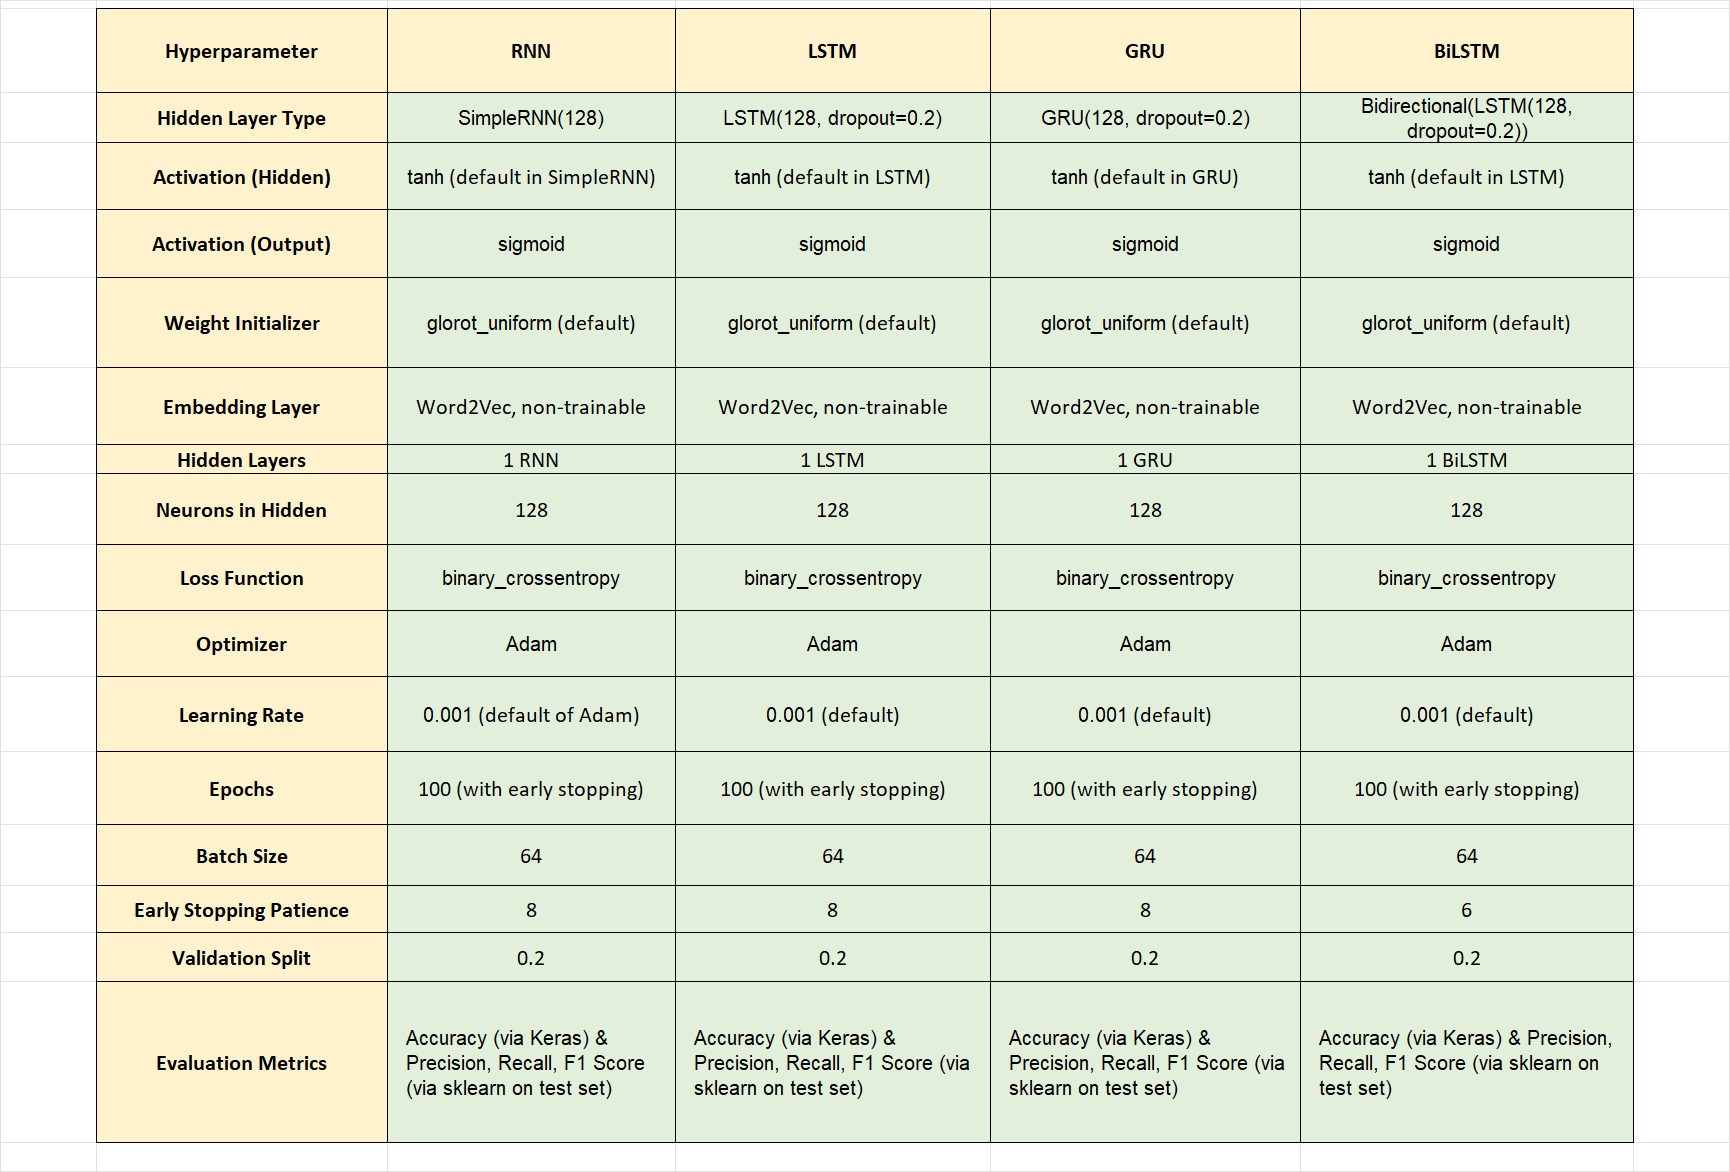